In [35]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy
import mne
import os
import pandas as pd

import tqdm
import IPython
import torchvision

import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torchvision.models import AlexNet
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from PIL import Image
from io import BytesIO
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
import pickle
import random
from tqdm import tqdm

In [36]:
def read_file(filename):
    with open(filename, 'rb') as handle:
        data = pickle.load(handle)
    return data

In [39]:
annotations = pd.read_csv('./annotations.csv', names=['filename', 'class'])
files = list(annotations['filename'])

In [40]:
#creating datasets from numpy arrays.
annotations = pd.read_csv('./annotations.csv', names=['filename', 'class'])
files = list(annotations['filename'])

y_full_np = np.array(list(annotations['class']))
partitions = np.array(read_file(files[0])).shape[1]
aux_list = []
for entry in y_full_np:
    entry_class = [entry for i in range(partitions)]
    aux_list.extend(entry_class)
y_full_np = np.array(aux_list)

x_full_pad = []
for file in files:
    x_full_pad.append(np.swapaxes(np.array(read_file(file)),0,1))
x_full_pad = np.concatenate(x_full_pad, axis=0)

In [41]:
indexes = [i for i in range(len(x_full_pad))]
train_len = 3*len(indexes)//4
val_len = len(indexes) - train_len
train_indexes = random.sample(indexes,train_len)
val_indexes = list(set(indexes).difference(set(train_indexes)))

In [44]:
x_train_pad = []
y_train_np = []
for index in train_indexes:
    x_train_pad.append(x_full_pad[index])
    y_train_np.append(y_full_np[index])
x_train_pad = np.array(x_train_pad)
y_train_np = np.array(y_train_np)
    
x_val_pad = []
y_val_np = []
for index in val_indexes:
    x_val_pad.append(x_full_pad[index])
    y_val_np.append(y_full_np[index])
x_val_pad = np.array(x_val_pad)
y_val_np = np.array(y_val_np)
    
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad.astype(np.float32)), torch.from_numpy(y_train_np.astype(np.int64)))
valid_data = TensorDataset(torch.from_numpy(x_val_pad.astype(np.float32)), torch.from_numpy(y_val_np.astype(np.int64)))

In [55]:
train_dataloader = DataLoader(train_data, batch_size=100, shuffle=True)
test_dataloader = DataLoader(valid_data, batch_size=100, shuffle=True)

In [56]:
def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("WARNING: For this notebook to perform best, "
                "if possible, in the menu under `Runtime` -> "
                "`Change runtime type.`  select `GPU` ")
    else:
        print("GPU is enabled in this notebook.")

    return device

DEVICE = set_device()

GPU is enabled in this notebook.


In [93]:
def train(model, device, train_loader):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    epochs = len(train_loader)
    losses = []
    for epoch in range(epochs):
        with tqdm(train_loader, unit='batch') as tepoch:
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=loss.item())
                losses.append(loss.item())
                #time.sleep(0.1)
    return losses

def test(model, device, data_loader):
    model.eval()
    correct = 0
    total = 0
    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(device).float()
        labels = labels.to(device).long()

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return acc

In [110]:
class Test_Net(nn.Module):
    def __init__(self):
        super(Test_Net, self).__init__()
        self.fc1 = nn.Linear(9*64, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 2)

    def forward(self, x):
        x = x.view(-1, 9*64)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.relu(x)
        x = self.fc6(x)
        x = F.relu(x)
        x = self.fc7(x)
        #x = F.relu(x)
        return x

## Uncomment the lines below to train your network
test_net = Test_Net().to(DEVICE)
accuracy = []

print("Total Parameters in Network {:10d}".format(sum(p.numel() for p in test_net.parameters())))
losses = train(test_net, DEVICE, train_dataloader)
acc = test(test_net, DEVICE, test_dataloader)
train_acc = test(test_net, DEVICE, train_dataloader)
accuracy.append(acc)

  0%|                                                                            | 0/15 [00:00<?, ?batch/s, loss=0.669]

Total Parameters in Network    3977282


100%|███████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 80.73batch/s, loss=0.409]


In [111]:
acc

73.3615221987315

In [112]:
train_acc

75.15878616796049

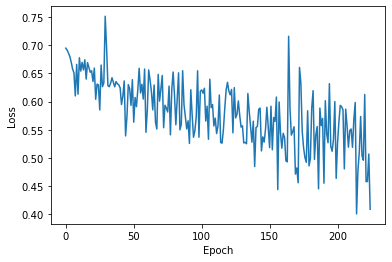

In [113]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(losses)
plt.show()

In [98]:
samples,no_chan,freqs = x_train_pad.shape
x_new = x_train_pad.reshape((samples,no_chan*freqs))
x_new.shape

(1417, 576)

In [99]:
y_train_np.shape

(1417,)

In [100]:
samples,no_chan,freqs = x_val_pad.shape
x_val_new = x_val_pad.reshape((samples,no_chan*freqs))
x_val_new.shape

(473, 576)

In [101]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(x_new, y_train_np)
clf.score(x_new, y_train_np)

0.6880733944954128

In [102]:
clf.score(x_val_new,y_val_np)

0.6596194503171248

In [24]:
class Test_Net(nn.Module):
    def __init__(self):
        super(Test_Net, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(9*1919, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 2),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
alexnet = torchvision.models.alexnet(pretrained=True)
num_ftrs = alexnet.fc.in_features
alexnet.classifier[6] = nn.Linear(4096, 2)
# reset final fully connected layer, number of classes = types of Pokemon = 9
alexnet.fc = nn.Linear(num_ftrs, 2)
alexnet.to(DEVICE)
optimizer = torch.optim.Adam(alexnet.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# @title Finetune ResNet

pretrained_accs = []
for epoch in tqdm.tqdm(range(10)):
  # Train loop
  for batch in train_dataloader:
    images, labels = batch
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
    output = alexnet(images)
    loss = loss_fn(output, labels)
    loss.backward()
    optimizer.step()

  # Eval loop
  with torch.no_grad():
    loss_sum = 0
    total_correct = 0
    total = len(y_val_np)
    for batch in test_dataloader:
      images, labels = batch
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      output = alexnet(images)
      loss = loss_fn(output, labels)
      loss_sum += loss.item()

      predictions = torch.argmax(output, dim=1)

      num_correct = torch.sum(predictions == labels)
      total_correct += num_correct

    # Plot accuracy
    pretrained_accs.append(total_correct / total)
    plt.plot(pretrained_accs)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Pokemon prediction accuracy')
    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf())
  plt.close()

In [ ]:
alexnet.eval()